In [1]:
from tensorflow import keras
from tensorflow.keras import layers

num_features = 14
inputs = keras.Input(shape = (None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


In [2]:

num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = True)(inputs)
print(outputs.shape)

(None, 120, 16)


### 과대적합을 감소시키기 위해 순환 드롭아웃 사용하기

In [7]:
# !wget http://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

--2023-07-13 01:00:10--  http://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.198, 16.182.96.224, 16.182.74.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2023-07-13 01:00:11 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [8]:
import os

fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f :
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [11]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines) :
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print('num_train_samples : ', num_train_samples)
print('num_val_samples : ', num_val_samples)
print('num_test_samples : ', num_test_samples)

num_train_samples :  210225
num_val_samples :  105112
num_test_samples :  105114


In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[: -delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[: -delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples  + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[: -delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

In [14]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',
                                    save_best_only = True)
]
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = 'mae')

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = val_dataset,
                    callbacks = callbacks)

Epoch 1/50
819/819 [==============================] - 35s 33ms/step - loss: 89.8726 - mae: 7.5860 - val_loss: 53.7528 - val_mae: 5.8817
Epoch 2/50
819/819 [==============================] - 26s 32ms/step - loss: 63.3230 - mae: 6.2536 - val_loss: 43.2392 - val_mae: 5.1503
Epoch 3/50
819/819 [==============================] - 26s 31ms/step - loss: 55.7665 - mae: 5.7962 - val_loss: 36.4183 - val_mae: 4.6871
Epoch 4/50
819/819 [==============================] - 26s 31ms/step - loss: 50.5622 - mae: 5.4750 - val_loss: 30.9402 - val_mae: 4.2792
Epoch 5/50
819/819 [==============================] - 26s 31ms/step - loss: 47.2138 - mae: 5.2681 - val_loss: 27.5538 - val_mae: 4.0383
Epoch 6/50
819/819 [==============================] - 26s 31ms/step - loss: 45.6070 - mae: 5.1667 - val_loss: 24.7560 - val_mae: 3.8120
Epoch 7/50
819/819 [==============================] - 26s 31ms/step - loss: 44.4476 - mae: 5.0918 - val_loss: 24.9364 - val_mae: 3.9259
Epoch 8/50
819/819 [============================

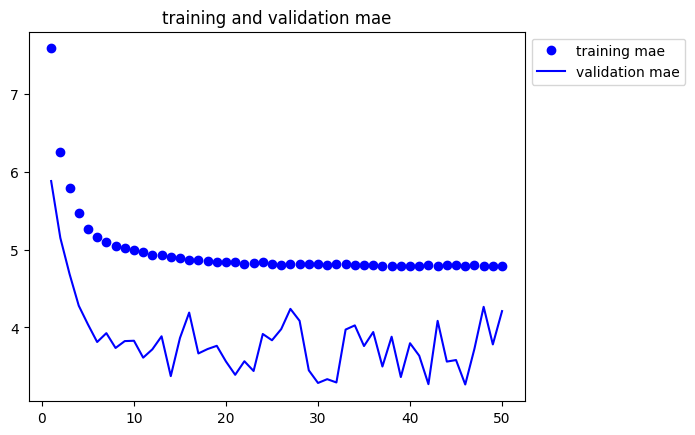

In [15]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'training mae')
plt.plot(epochs, val_loss, 'b', label = 'validation mae')
plt.title('training and validation mae')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

plt.show()

In [17]:
from keras.engine.training import callbacks_module
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

x = layers.GRU(32, return_sequences = True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras',
                                    save_best_only = True)
]
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model('jena_stacked_gru_dropout.keras')
print(f'테스트 mae : {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/50
819/819 [==============================] - 31s 34ms/step - loss: 44.3090 - mae: 5.1702 - val_loss: 26.2848 - val_mae: 4.0126
Epoch 2/50
819/819 [==============================] - 27s 33ms/step - loss: 31.9909 - mae: 4.4544 - val_loss: 25.3409 - val_mae: 3.9499
Epoch 3/50
819/819 [==============================] - 27s 33ms/step - loss: 29.9206 - mae: 4.3135 - val_loss: 26.6136 - val_mae: 4.0300
Epoch 4/50
819/819 [==============================] - 27s 32ms/step - loss: 28.5634 - mae: 4.2129 - val_loss: 27.9073 - val_mae: 4.1262
Epoch 5/50
819/819 [==============================] - 27s 33ms/step - loss: 27.9162 - mae: 4.1670 - val_loss: 26.3272 - val_mae: 4.0084
Epoch 6/50
819/819 [==============================] - 27s 32ms/step - loss: 27.5947 - mae: 4.1466 - val_loss: 23.5765 - val_mae: 3.7735
Epoch 7/50
819/819 [==============================] - 27s 32ms/step - loss: 27.1443 - mae: 4.1111 - val_loss: 20.3887 - val_mae: 3.5576
Epoch 8/50
819/819 [============================

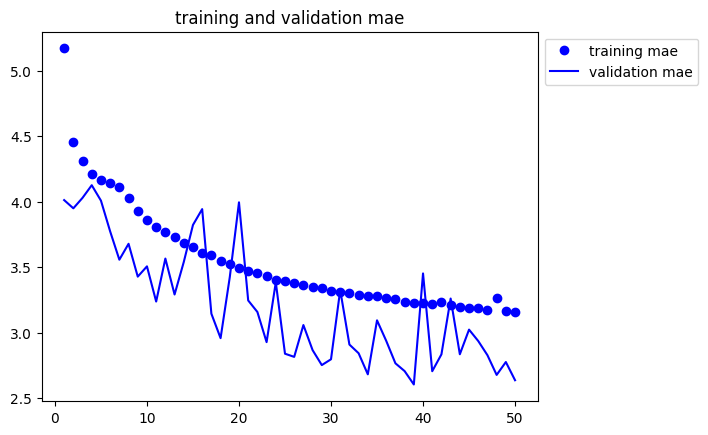

In [18]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'training mae')
plt.plot(epochs, val_loss, 'b', label = 'validation mae')
plt.title('training and validation mae')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

plt.show()

### 양방향 rnn

In [24]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
819/819 [==============================] - 31s 34ms/step - loss: 115.2442 - mae: 8.7284 - val_loss: 79.3556 - val_mae: 7.2289
Epoch 2/10
819/819 [==============================] - 32s 39ms/step - loss: 71.7238 - mae: 6.7824 - val_loss: 57.0031 - val_mae: 6.1159
Epoch 3/10
819/819 [==============================] - 35s 42ms/step - loss: 64.6225 - mae: 6.3720 - val_loss: 52.7543 - val_mae: 5.8377
Epoch 4/10
819/819 [==============================] - 31s 38ms/step - loss: 60.0806 - mae: 6.0881 - val_loss: 48.6655 - val_mae: 5.5678
Epoch 5/10
819/819 [==============================] - 35s 42ms/step - loss: 55.8680 - mae: 5.8218 - val_loss: 45.0748 - val_mae: 5.3176
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 51.9653 - mae: 5.5734 - val_loss: 41.4743 - val_mae: 5.0579
Epoch 7/10
819/819 [==============================] - 34s 41ms/step - loss: 48.3811 - mae: 5.3437 - val_loss: 38.3612 - val_mae: 4.8363
Epoch 8/10
819/819 [===========================

### 텍스트를 위한 딥러닝

In [38]:
import string

class Vectorizer :
  def standardize(self, text) :
    text = text.lower()
    return ''.join(char for char in text if char not in string.punctuation)


  def tokenize(self, text) :
    return text.split()

  def make_vocabulary(self, dataset) :
    self.vocabulary = {'' : 0, '[UNK]' : 1} # 특수한 토큰인 '' (비어있는 문자열)과 '[UNK]' 알려지지 않은 토큰을 초기값으로 설정

    for text in dataset :
      text = self.standardize(text)
      tokens = self.tokenize(text)
      for token in tokens :
        if token not in self.vocabulary :
          self.vocabulary[token] = len(self.vocabulary) # 단어 집합에 이미 들어있는 토큰의 개수로, 각 토큰에 고유한 정수를 할당
    self.inverse_vocabulary = dict(
        (v,k) for k, v in self.vocabulary.items()) # self.vacabulary는 단어를 키로 하고 해당 단어에 대응하는 고유한 정수를 값
                                                  # self.inverse_vacabulary 정수를 키로 하고 단어를 값으로 가지는 딕셔너리
  def encode(self, text) :
    text = self.standardize(text)
    tokens = self.tokenize(text)
    return  [self.vocabulary.get(token, 1) for token in tokens] # 토큰이 단어 집합에 없다면 1을 반환

  def decode(self, int_sequence) :
    return ' '.join(self. inverse_vocabulary.get(i, '[UNK]') for i in int_sequence) # 정수가 단어 집합에 없다면 '[UNK]' 를 반환

vectorizer = Vectorizer()
dataset = [
    'i write, erase, rewrite',
    'erase again, and then',
    'A poppy blooms.'
]
vectorizer.make_vocabulary(dataset)

In [36]:
test_sentence = 'l write, rewrite, and still rewrite again'
encoded_sentence = vectorizer.encode(test_sentence)

print(encoded_sentence)

[1, 3, 5, 7, 1, 5, 6]


In [39]:
decoded_sentence = vectorizer.decode(encoded_sentence)

print(decoded_sentence)

[UNK] write rewrite and [UNK] rewrite again


In [40]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode = 'int',
)

In [41]:
import re
import string
import tensorflow as tf

In [42]:
def custom_standardization_fn(string_tensor) :
  lowercase_string = tf.strings.lower(string_tensor)
  return tf.strings.regex_replace(
      lowercase_string, f'[{re.escape(string.punctuation)}]', ''
  )

def custom_split_fn(string_tensor) :
  return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode = 'int',
    standardize = custom_standardization_fn,
    split = custom_split_fn,
)


In [43]:
dataset = [
    'l write, erase, rewrite',
    'Erase again, and then',
    'A poppy blooms.']

text_vectorization.adapt(dataset)

In [44]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'l',
 'blooms',
 'and',
 'again',
 'a']

In [45]:
vacabulary = text_vectorization.get_vocabulary()
test_sentence = 'i write, rewrite, and still rewrite again'
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 1  3  5  9  1  5 10], shape=(7,), dtype=int64)


### 단어 그룹을 표현하는 두가지 방법 : 집합과 시퀀스

imdb 영화 리뷰 데이터 준비

In [61]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

In [62]:
# !rm -r aclImdb/train/unsup

In [63]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [67]:
import os, pathlib, shutil, random

base_dir = pathlib.Path('aclImdb')
val_dir = base_dir / 'val'
train_dir = base_dir / 'train'
!rm -r aclImdb/val/neg
for category in ('neg', 'pos') :
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]

  for fname in val_files :
    shutil.move(train_dir / category / fname,
                val_dir / category / fname)

In [68]:
!ls

aclImdb			    jena_climate_2009_2016.csv.zip  __MACOSX
aclImdb_v1.tar.gz	    jena_lstm_dropout.keras	    sample_data
acllmdb			    jena_stacked_gru_dropout.keras
jena_climate_2009_2016.csv  jene_stacked_gru_dropout.keras


In [73]:
from tensorflow import keras

batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size
)

Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [74]:
for inputs, targets in train_ds :
  print('inputs.shape : ', inputs.shape)
  print('inputs.dtype : ', inputs.dtype)
  print('targets.shape : ', targets.shape)
  print('targets.dtype : ', targets.dtype)
  print('inputs[0] : ', inputs[0])
  print('inputs[0] : ', targets[0])
  break

inputs.shape :  (32,)
inputs.dtype :  <dtype: 'string'>
targets.shape :  (32,)
targets.dtype :  <dtype: 'int32'>
inputs[0] :  tf.Tensor(b'This movie is simply incredible! I had expected something quite different form the film that I actually saw. However, it is very insightful in that it shows the aggressive nature of human sexuality and its linkage with animal behavior. Let me warn those among the readers of this article who are easily offended by content that is all too sexual, for the explicit sexual nature of this film feels like a high-brow sort of pornography. It even features a scene that comes extremely close to rape.<br /><br />Meanwhile, I strongly suggest seeing this rare work of "sexual art". Every minute of the picture breathes the sexual spirit of the seventies, by the way. One should not forget how times have changed!<br /><br />Go see it! It\xc2\xb4s worth your money and time!', shape=(), dtype=string)
inputs[0] :  tf.Tensor(1, shape=(), dtype=int32)
